# LangSmith and Evaluation Overview with AI Makerspace

Today we'll be looking at an amazing tool:

[LangSmith](https://docs.smith.langchain.com/)!

This tool will help us monitor, test, debug, and evaluate our LangChain applications - and more!

We'll also be looking at a few Advanced Retrieval techniques along the way - and evaluate it using LangSmith!

✋BREAKOUT ROOM #2:
- Task 1: Dependencies and OpenAI API Key
- Task 2: LangGraph RAG
- Task 3: Setting Up LangSmith
- Task 4: Examining the Trace in LangSmith!
- Task 5: Create Testing Dataset
- Task 6: Evaluation

## Task 1: Dependencies and OpenAI API Key

We'll be using OpenAI's suite of models today to help us generate and embed our documents for our simple RAG system that leverages Loand Complaint data.

In [30]:
import os
import getpass

os.environ["OPENAI_API_KEY"] = getpass.getpass("Enter your OpenAI API Key:")

#### Asyncio Bug Handling

In [2]:
import nest_asyncio
nest_asyncio.apply()

## Task #2: Create a Simple RAG Application Using LangGraph

Let's remake our LangGraph RAG pipeline from the first notebook!

## LangGraph Powered RAG

First and foremost, LangChain provides a convenient way to store our chunks and their embeddings.

It's called a `VectorStore`!

We'll be using QDrant as our `VectorStore` today. You can read more about it [here](https://qdrant.tech/documentation/).

Think of a `VectorStore` as a smart way to house your chunks and their associated embedding vectors. The implementation of the `VectorStore` also allows for smarter and more efficient search of our embedding vectors - as the method we used above would not scale well as we got into the millions of chunks.

Otherwise, the process remains relatively similar under the hood!

### Data Collection

We'll be leveraging the `DirectoryLoader` to load our PDFs!

In [3]:
from langchain_community.document_loaders import DirectoryLoader
from langchain_community.document_loaders import PyMuPDFLoader

directory_loader = DirectoryLoader("data", glob="**/*.pdf", loader_cls=PyMuPDFLoader)

loan_knowledge_resources = directory_loader.load()

### Chunking Our Documents

Let's do the same process as we did before with our `RecursiveCharacterTextSplitter` - but this time we'll use ~200 tokens as our max chunk size!

In [4]:
import tiktoken
from langchain.text_splitter import RecursiveCharacterTextSplitter

def tiktoken_len(text):
    tokens = tiktoken.encoding_for_model("gpt-4o").encode(
        text,
    )
    return len(tokens)

text_splitter = RecursiveCharacterTextSplitter(
    chunk_size = 750,
    chunk_overlap = 0,
    length_function = tiktoken_len,
)
loan_knowledge_chunks = text_splitter.split_documents(loan_knowledge_resources)

In [5]:
len(loan_knowledge_chunks)

375

Let's verify the process worked as intended by checking our max document length.

In [6]:
max_chunk_length = 0

for chunk in loan_knowledge_chunks:
  max_chunk_length = max(max_chunk_length, tiktoken_len(chunk.page_content))

print(max_chunk_length)

742


Perfect! Now we can carry on to creating and storing our embeddings.

### Embeddings and Vector Storage

We'll use the `text-embedding-3-small` embedding model again - and `Qdrant` to store all our embedding vectors for easy retrieval later!

In [20]:
from langchain_community.vectorstores import Qdrant
from langchain_openai.embeddings import OpenAIEmbeddings

embedding_model = OpenAIEmbeddings(model="text-embedding-3-small")

qdrant_vectorstore = Qdrant.from_documents(
    documents=loan_knowledge_chunks,
    embedding=embedding_model,
    location=":memory:"
)

Now let's set up our retriever, just as we saw before, but this time using LangChain's simple `as_retriever()` method!

In [21]:
qdrant_retriever = qdrant_vectorstore.as_retriever()

#### Back to the Flow

We're ready to move to the next step!

### Setting up our RAG

We'll use the same LangGraph pipeline we created in the first notebook. 

Let's think through each part:

1. First we need to retrieve context
2. We need to pipe that context to our model
3. We need to parse that output

Let's start by setting up our prompt again, just so it's fresh in our minds!

#### 🏗️ Activity #2:

Complete the prompt so that your RAG application answers queries based on the context provided, but *does not* answer queries if the context is unrelated to the query.

In [32]:
from langchain_core.prompts import ChatPromptTemplate

HUMAN_TEMPLATE = """
#CONTEXT:
{context}

QUERY:
{query}

Use the provide context to answer the provided user query. Only use the provided context to answer the query. If you do not know the answer, or it's not contained in the provided context respond with "I don't know"
"""

chat_prompt = ChatPromptTemplate.from_messages([
    ("human", HUMAN_TEMPLATE)
])

We'll set our Generator - `gpt-4.1-nano` in this case - below!

In [33]:
from langchain_openai import ChatOpenAI

openai_chat_model = ChatOpenAI(model="gpt-4.1-nano")

#### Our RAG Application

Let's spin up the graph.

In [34]:
from langgraph.graph import START, StateGraph
from typing_extensions import TypedDict
from langchain_core.documents import Document
from langchain_core.output_parsers import StrOutputParser

class State(TypedDict):
  question: str
  context: list[Document]
  response: str

def retrieve(state: State) -> State:
  retrieved_docs = qdrant_retriever.invoke(state["question"])
  return {"context" : retrieved_docs}

def generate(state: State) -> State:
  generator_chain = chat_prompt | openai_chat_model | StrOutputParser()
  response = generator_chain.invoke({"query" : state["question"], "context" : state["context"]})
  return {"response" : response}

graph_builder = StateGraph(State)
graph_builder = graph_builder.add_sequence([retrieve, generate])
graph_builder.add_edge(START, "retrieve")
rag_graph = graph_builder.compile()

Let's get a visual understanding of our chain!

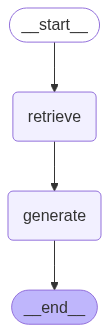

In [35]:
rag_graph

Let's test our chain out!

In [36]:
response = rag_graph.invoke({"question" : "Is applying for and securing a student loan in 2025 a terrible idea?"})

In [37]:
response["response"]

"I don't know"

In [38]:
for context in response["context"]:
  print("Context:")
  print(context.page_content[:100])
  print("----")

Context:
student to earn that number of credits. For instance, if your school has a baccalaureate program tha
----
Context:
You must confirm that the borrower meets the definition of eligible borrower by doing the following:
----
Context:
Regardless of the counseling methods your school uses, it must document that the student received en
----
Context:
Pell Grant Lifetime Eligibility Used
Before awarding a Pell Grant, you must check the COD common rec
----


Let's see if it can handle a query that is totally unrelated to the source documents.

In [39]:
response = rag_graph.invoke({"question" : "What is the airspeed velocity of an unladen swallow?"})

In [40]:
response["response"]

"I don't know"

## Task 3: Setting Up LangSmith

Now that we have a chain - we're ready to get started with LangSmith!

We're going to go ahead and use the following `env` variables to get our Colab notebook set up to start reporting.

If all you needed was simple monitoring - this is all you would need to do!

In [41]:
from uuid import uuid4

unique_id = uuid4().hex[0:8]

os.environ["LANGSMITH_TRACING"] = "true"
os.environ["LANGSMITH_PROJECT"] = f"LangSmith - {unique_id}"

### LangSmith API

In order to use LangSmith - you will need an API key. You can sign up for a free account on [LangSmith's homepage!](https://www.langchain.com/langsmith)

Once you have created your account, Take the navigation option for `Settings` then `API Keys` to create an API key.

In [42]:
os.environ["LANGSMITH_API_KEY"] = getpass.getpass('Enter your LangSmith API key: ')

Let's test our our first generation!

In [43]:
rag_graph.invoke({"question" : "What is the maximum loan amount I can get from the government to go to school these days?"}, {"tags" : ["Demo Run"]})['response']

'Based on the provided context, the maximum loan amount you can receive from the government depends on your student status and year in school. For example:\n\n- A dependent first-year undergraduate can receive up to $5,500 annually, with no more than $3,500 of that subsidized.\n- A dependent second-year undergraduate can receive up to $6,500 annually, with no more than $4,500 subsidized.\n- For students progressing to higher grade levels during an academic year, the limits can increase accordingly, such as up to $7,500 for third-year and beyond dependents, with a maximum of $5,500 subsidized.\n\nAdditionally, there are aggregate limits:\n- For dependent undergraduates (excluding those whose parents can’t get Direct PLUS Loans), the total maximum is $31,000, with up to $23,000 subsidized.\n- For independent undergraduates (and dependent students whose parents can’t get Direct PLUS Loans), the total maximum is $57,500, with up to $23,000 subsidized.\n- Graduate and professional students 

## Task 4: Examining the Trace in LangSmith!

Head on over to your LangSmith web UI to check out how the trace looks in LangSmith!

#### 🏗️ Activity #1:

Include a screenshot of your trace and explain what it means.

##### ✅ Answer:

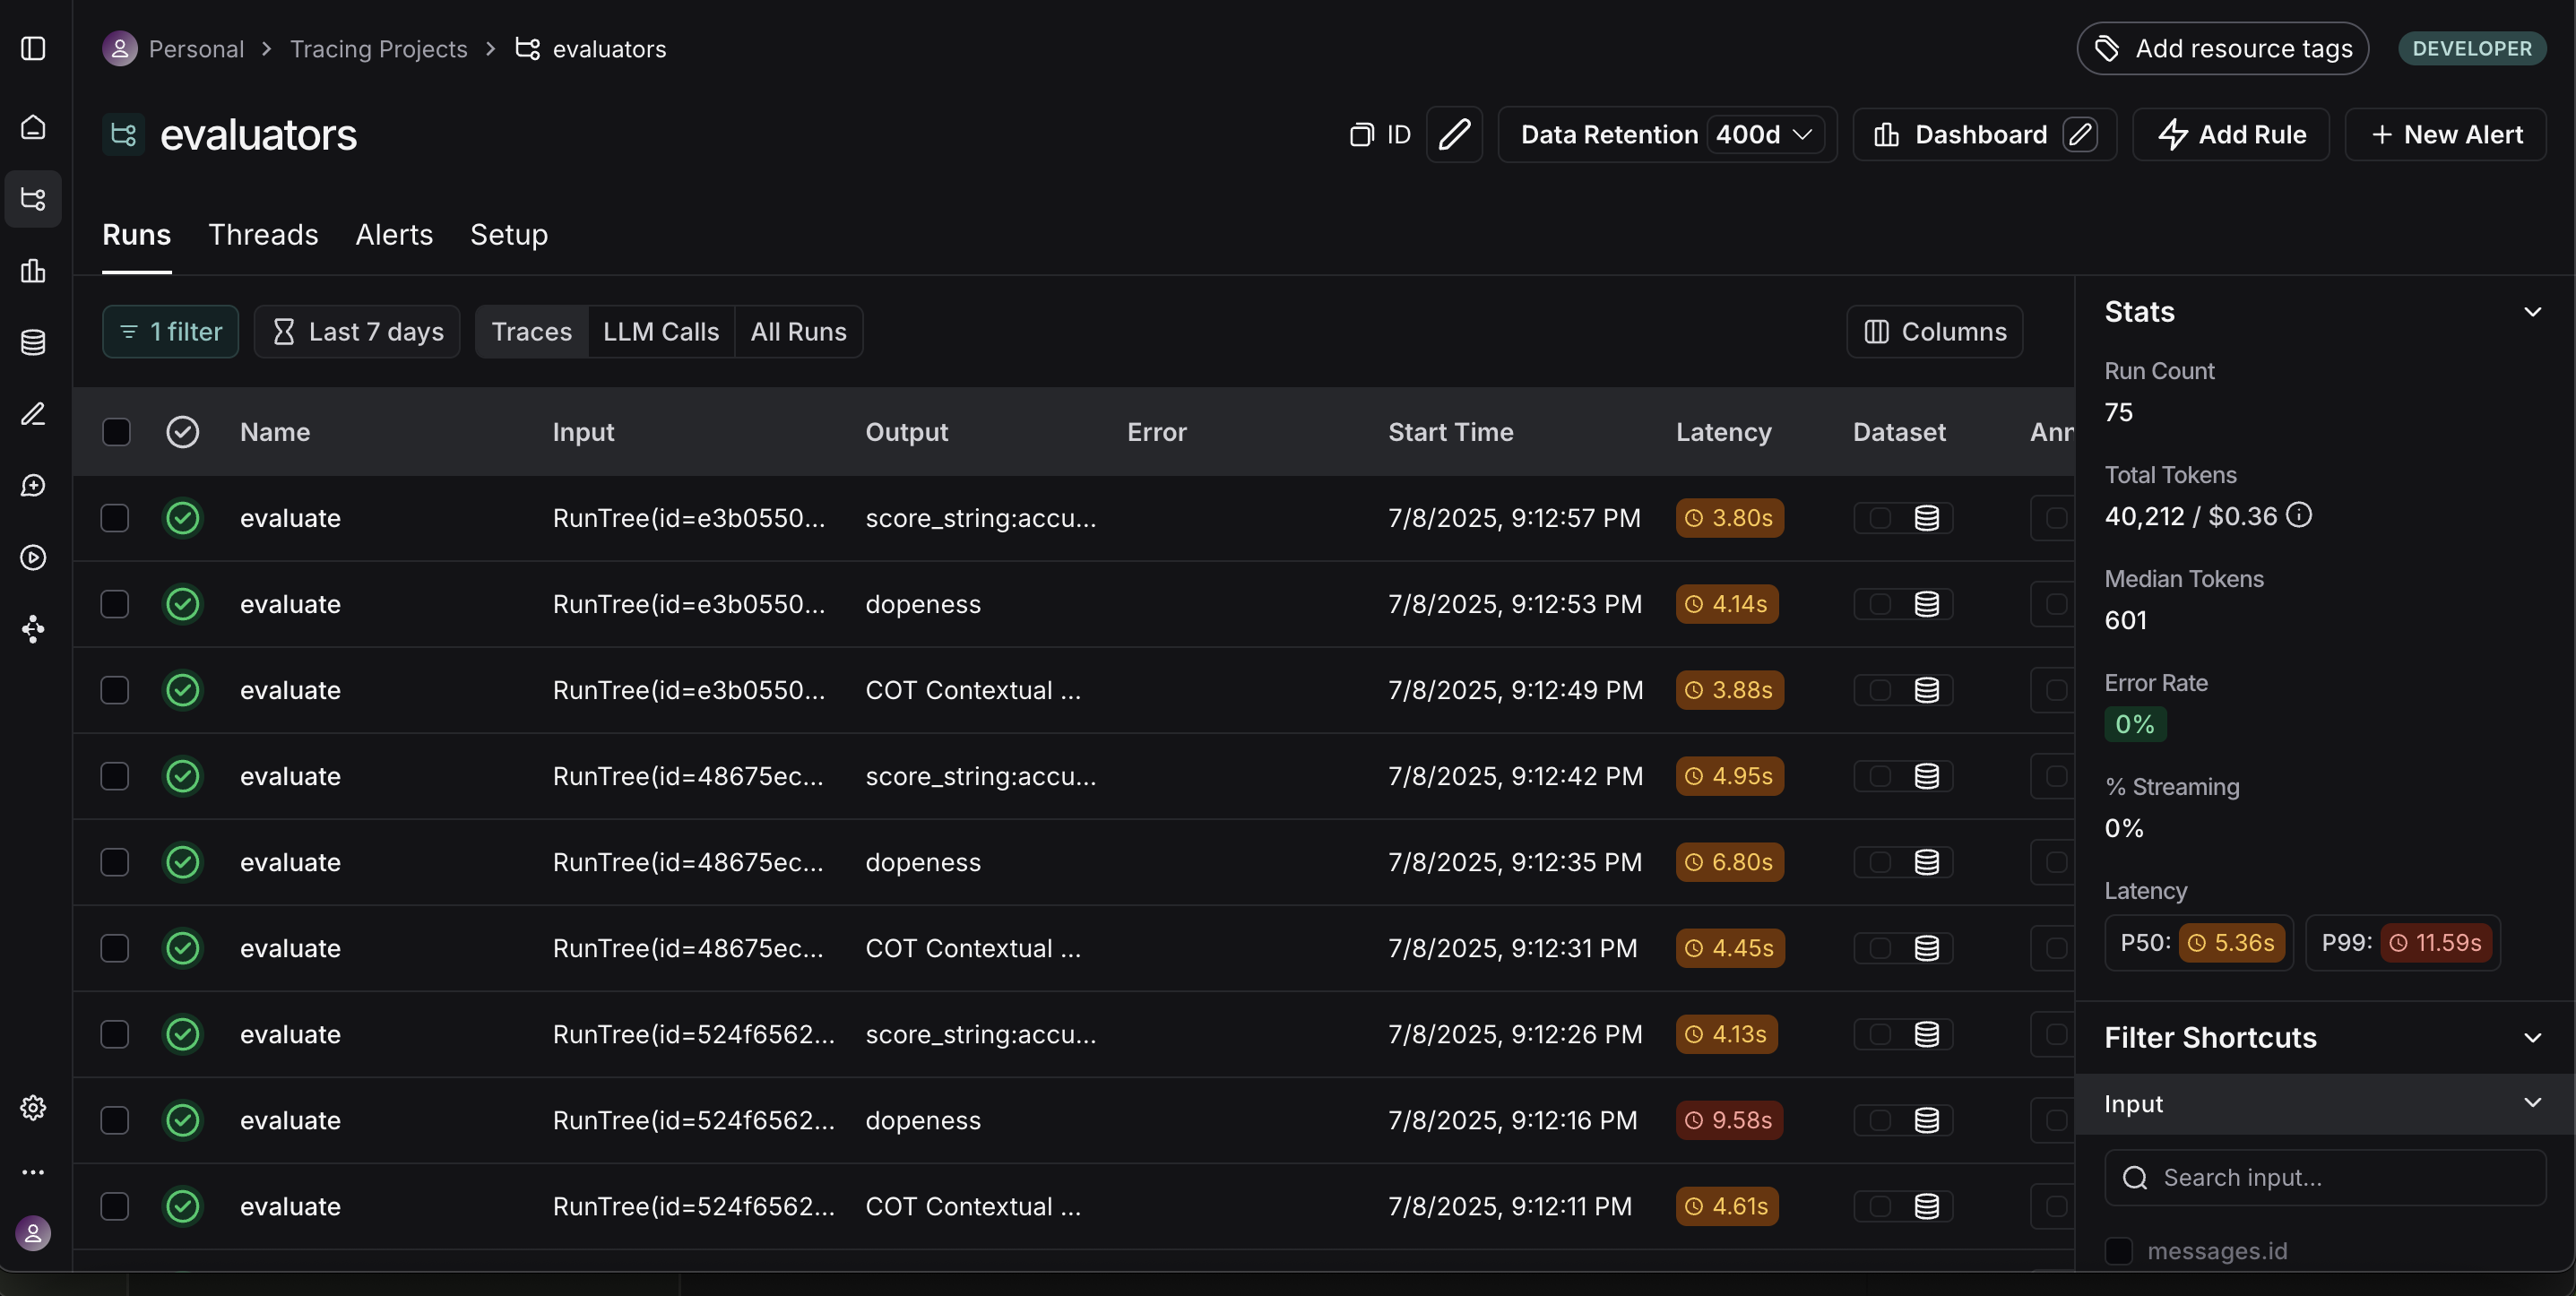 

This screenshot shows an overview of all our evaluator runs in LangSmith. Each row represents a single evaluation using one of our evaluator chains (like score_string:accuracy, dopeness, or COT Contextual). All evaluations completed successfully, with zero errors and moderate latency.


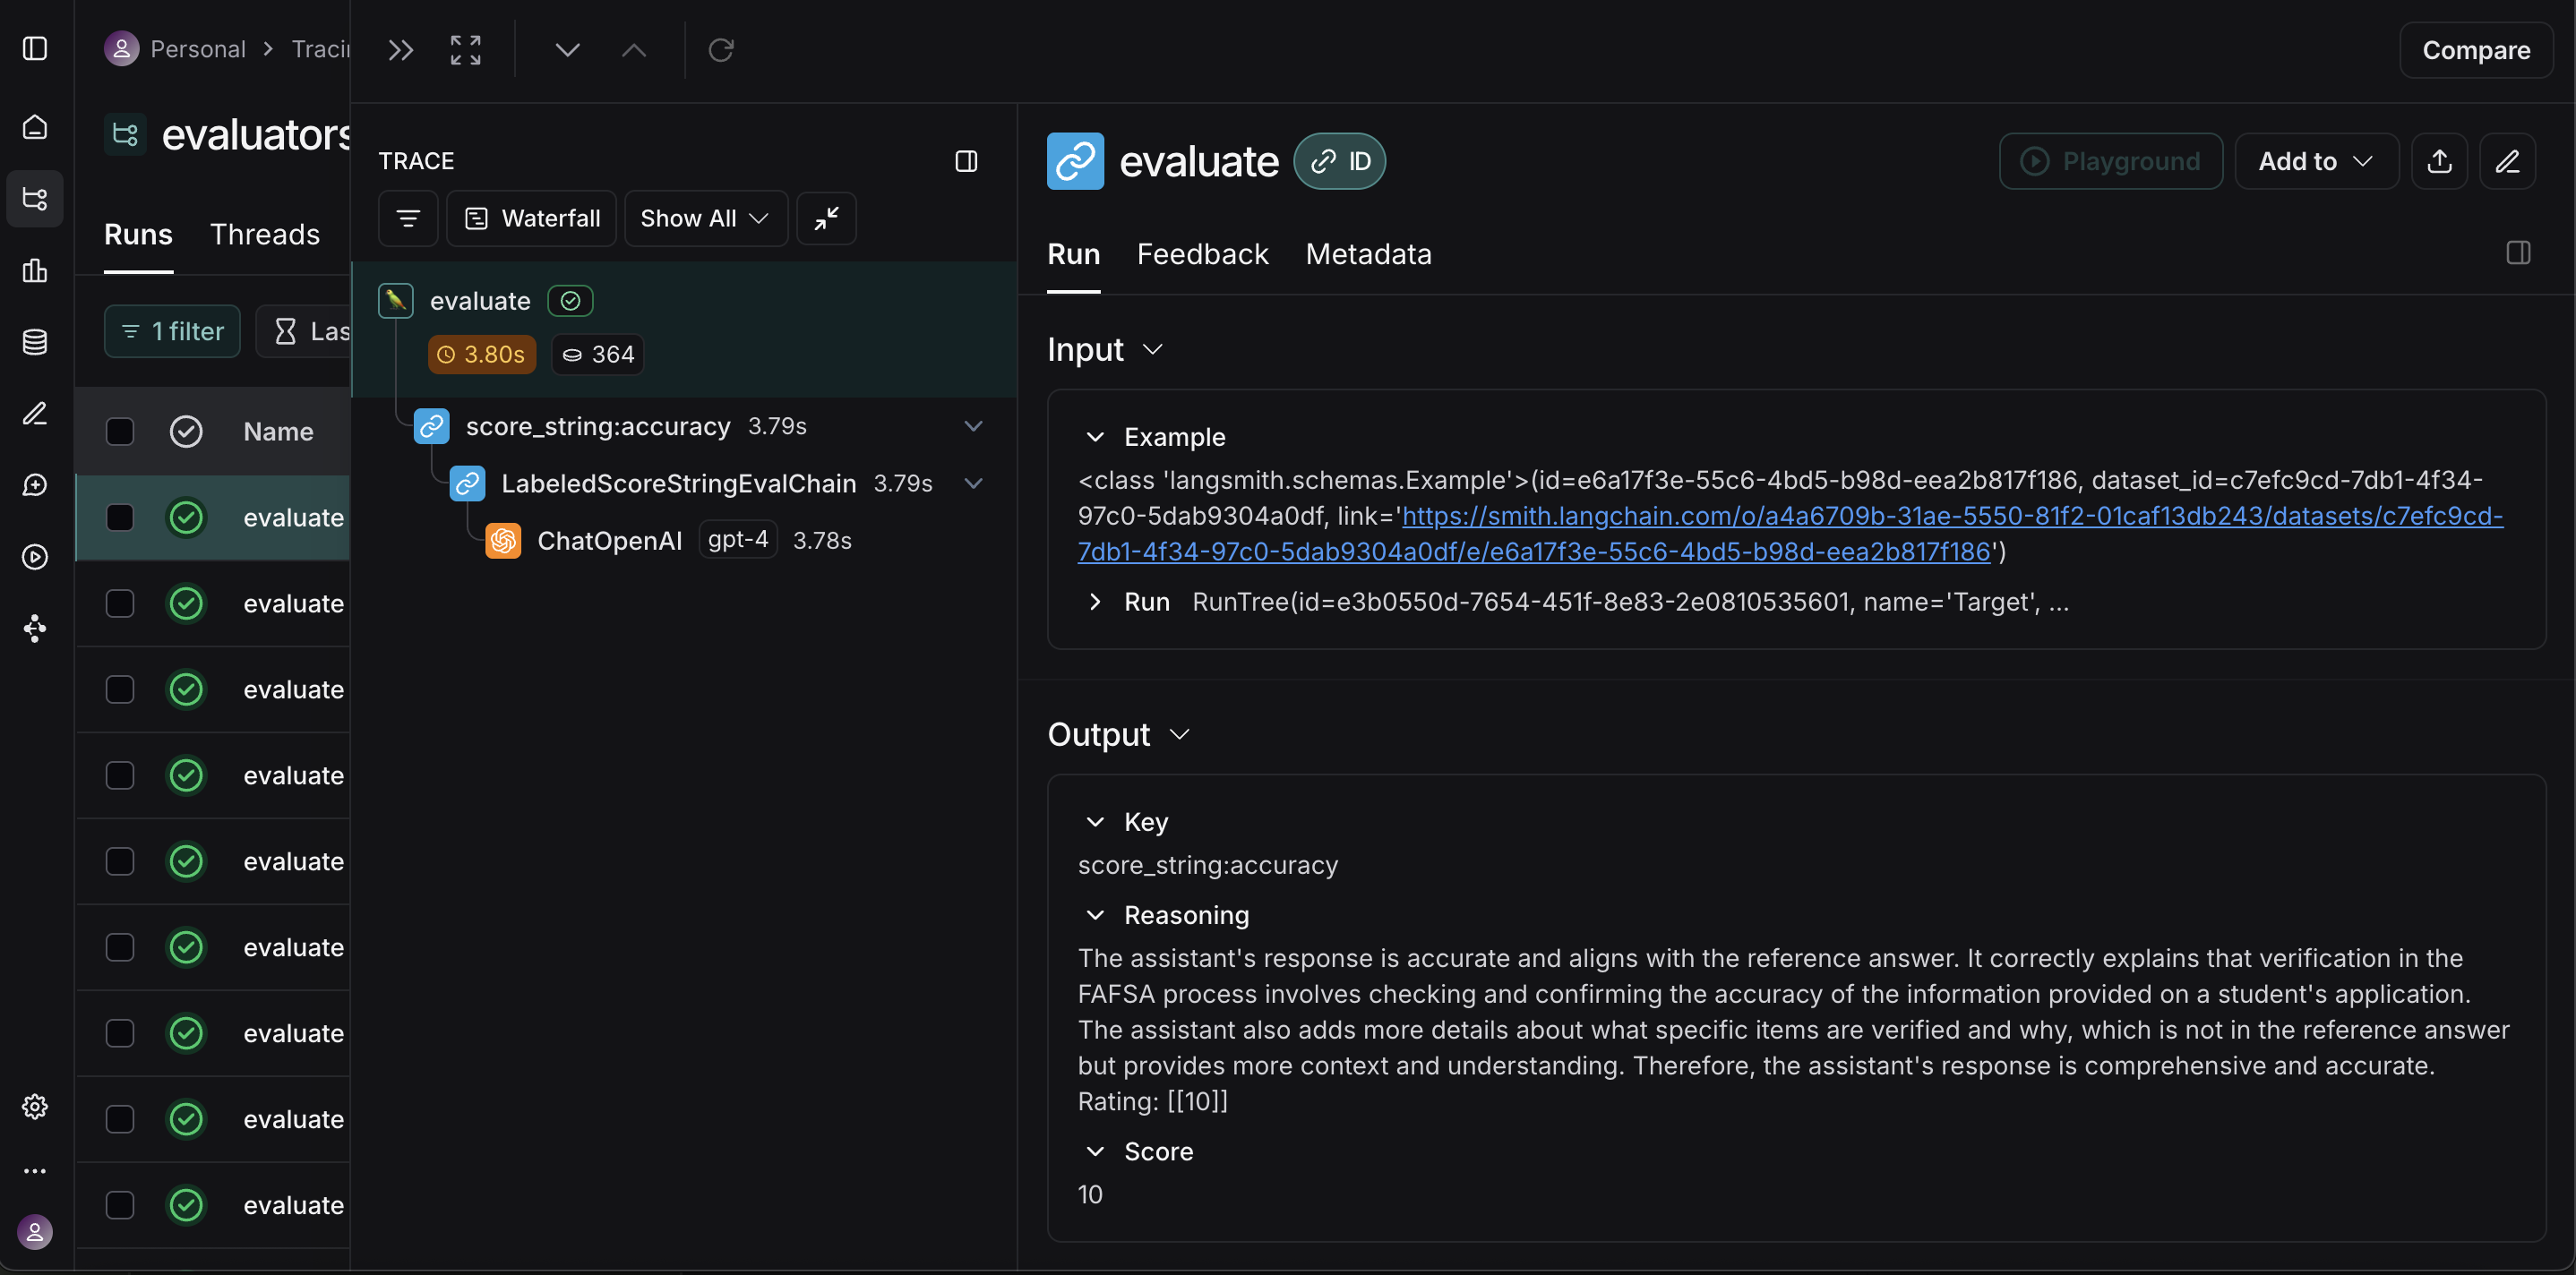


This second screenshot shows a detailed trace of a single evaluation run, specifically for the `score_string:accuracy` evaluator. In this instance, the evaluator assigned a perfect score of 10, indicating that the assistant’s response fully aligned with the reference answer. The reasoning provided explains that the assistant accurately described the FAFSA verification process and even added helpful context that wasn’t included in the reference, which strengthened the quality of the answer. The trace also reveals the full evaluation chain—from the `evaluate` wrapper, through the `LabeledScoreStringEvalChain`, down to the final GPT-4 API call—along with all inputs, outputs, and the evaluator’s rationale.

## Task 5: Loading Our Testing Set

In [44]:
!git clone https://github.com/AI-Maker-Space/DataRepository.git

Python(93060) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
10887.18s - pydevd: Sending message related to process being replaced timed-out after 5 seconds


Cloning into 'DataRepository'...
remote: Enumerating objects: 122, done.
remote: Counting objects: 100% (114/114), done.
remote: Compressing objects: 100% (99/99), done.
remote: Total 122 (delta 37), reused 39 (delta 10), pack-reused 8 (from 1)
Receiving objects: 100% (122/122), 78.04 MiB | 896.00 KiB/s, done.
Resolving deltas: 100% (37/37), done.


In [45]:
import pandas as pd

test_df = pd.read_csv("DataRepository/student_loan_rag_test_data.csv")

Now we can set up our LangSmith client - and we'll add the above created dataset to our LangSmith instance!

> NOTE: Read more about this process [here](https://docs.smith.langchain.com/old/evaluation/faq/manage-datasets#create-from-list-of-values)

In [46]:
from langsmith import Client

client = Client()

dataset_name = "langsmith-student-loan-rag"

dataset = client.create_dataset(
    dataset_name=dataset_name, description="Student Loan RAG Test Questions"
)

for triplet in test_df.iterrows():
  triplet = triplet[1]
  client.create_example(
      inputs={"question" : triplet["question"], "context": triplet["context"]},
      outputs={"answer" : triplet["answer"]},
      dataset_id=dataset.id
  )

## Task 6: Evaluation

Now we can run the evaluation!

We'll need to start by preparing some custom data preparation functions to ensure our chain works with the expected inputs/outputs from the `evaluate` process in LangSmith.

> NOTE: More reading on this available [here](https://docs.smith.langchain.com/how_to_guides/evaluation/evaluate_llm_application#evaluate-a-langchain-runnable)

In [47]:
def prepare_data_ref(run, example):
  return {
      "prediction" : run.outputs["response"],
      "reference" : example.outputs["answer"],
      "input" : example.inputs["question"]
  }

def prepare_data_noref(run, example):
  return {
      "prediction" : run.outputs["response"],
      "input" : example.inputs["question"]
  }

def prepare_context_ref(run, example):
  return {
      "prediction" : run.outputs["response"],
      "reference" : example.inputs["context"],
      "input" : example.inputs["question"]
  }

We'll be using a few custom evaluators to evaluate our pipeline, as well as a few "built in" methods!

Check out the built-ins [here](https://docs.smith.langchain.com/reference/sdk_reference/langchain_evaluators)!

In [48]:
from langsmith.evaluation import LangChainStringEvaluator, evaluate

eval_llm = ChatOpenAI(model="gpt-4o-mini", tags=["eval_llm"])

cot_qa_evaluator = LangChainStringEvaluator("cot_qa",  config={"llm":eval_llm}, prepare_data=prepare_context_ref)

unlabeled_dopeness_evaluator = LangChainStringEvaluator(
    "criteria",
    config={
        "criteria" : {
            "dopeness" : "Is the answer to the question dope, meaning cool - awesome - and legit?"
        },
        "llm" : eval_llm,
    },
    prepare_data=prepare_data_noref
)

labeled_score_evaluator = LangChainStringEvaluator(
    "labeled_score_string",
    config={
        "criteria": {
            "accuracy": "Is the generated answer the same as the reference answer?"
        },
    },
    prepare_data=prepare_data_ref
)

base_rag_results = evaluate(
    rag_graph.invoke,
    data=dataset_name,
    evaluators=[
        cot_qa_evaluator,
        unlabeled_dopeness_evaluator,
        labeled_score_evaluator,
        ],
    experiment_prefix="Base RAG Evaluation"
)

Python(93887) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(93959) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(93963) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(93964) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(93969) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(93975) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(93978) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(93988) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(93990) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(93992) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(94002) Malloc

View the evaluation results for experiment: 'Base RAG Evaluation-0b2acd42' at:
https://smith.langchain.com/o/a4a6709b-31ae-5550-81f2-01caf13db243/datasets/c7efc9cd-7db1-4f34-97c0-5dab9304a0df/compare?selectedSessions=53c4945d-6a34-485a-8851-13d75364e3be




Python(94056) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


0it [00:00, ?it/s]

0.00s - Debugger warning: It seems that frozen modules are being used, which may
0.00s - make the debugger miss breakpoints. Please pass -Xfrozen_modules=off
0.00s - to python to disable frozen modules.
0.00s - Note: Debugging will proceed. Set PYDEVD_DISABLE_FILE_VALIDATION=1 to disable this validation.


#### ❓Question #1:

What conclusions can you draw about the above results?

Describe in your own words what the metrics are expressing.


##### ✅ Answer:

Looking at the evaluation table, we can see that our RAG pipeline performs very reliably and efficiently. The **Cot Contextual** column is 1.00 on average—meaning every answer passed our chain-of-thought quality check as “correct.” The **Score\_string\:accuracy** average of **8.26** tells us that most answers closely match the reference, though a few are missing minor details. In contrast, the **Dopeness** metric averages only **0.26**, with many marked “n,” indicating that while our responses are factually accurate, they aren’t yet very dope. Finally, the **Latency** P50 of **1.67 s** (and P99 around 3–4 s) shows that half of our evaluations finish in under two seconds and even the slowest ones complete in just a few seconds. Altogether, these metrics tell us that the system is reliable and fast, highly accurate but could be improved in dopeness.